In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from PrayTimes import prayTimes
import requests
from bs4 import BeautifulSoup

In [2]:
def get_flight_history(flight_number, sel_index = 0):
    url = 'https://www.flightaware.com/live/flight/' + flight_number + '/history'
    hist_link = []
    # Define headers to mimic a browser request
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.164 Safari/537.36',
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8',
        'Accept-Language': 'en-US,en;q=0.5',
        'Accept-Encoding': 'gzip, deflate, br',
        'DNT': '1',
        'Connection': 'keep-alive',
        'Upgrade-Insecure-Requests': '1'
    }

    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()  # Raise an exception for HTTP errors
        soup = BeautifulSoup(response.text, 'html.parser')
        # Find the link with the specific pattern
        for link in soup.find_all('a'):
            href = link.get('href')
            if href and '/history/2' in href:
                hist_link = hist_link + ['https://www.flightaware.com' + href]
                print('https://www.flightaware.com' + href)


    except requests.exceptions.RequestException as e:
        print(f"Request error: {e}")
    print(hist_link)
    print('_ selected: ___')
    print(hist_link[sel_index])
    print('_______________')

    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) " \
                      "AppleWebKit/537.36 (KHTML, like Gecko) " \
                      "Chrome/114.0.0.0 Safari/537.36"
        }
    url = hist_link[sel_index]+"/tracklog"
    print(url)
    resp = requests.get(url, headers = headers)
    resp.raise_for_status()  # Raise error on bad response

    soup = BeautifulSoup(resp.text, "html.parser")
    table = soup.find_all('table')
    df = pd.read_html(str(table))
    return df

def Parse24HrTime(time_24hr):
    invalidTime =  '-----'
    if time_24hr == invalidTime:
        return np.nan, np.nan
    if time_24hr[0] == '-':
        hr = 0
        mins = 0
    else:  
        hr = int(time_24hr.split(":")[0])
        mins = int(time_24hr.split(":")[1])

    
    return(hr, mins)

def Extract24HrTime(time_12hr):
    invalidTime =  '-----'
    if time_12hr == invalidTime:
        return np.nan, np.nan
    else:
        exc_day = time_12hr[-2:]
        exc_time = time_12hr[:-3]
        hr = int(exc_time.split(":")[0])
        mins = int(exc_time.split(":")[1])

        if exc_day == 'PM':
            if hr != 12:
                hr += 12
        else:
            if hr == 12:
                hr = 0

        return(hr, mins)

def ConvertTo12Hr(time_24):
    mins = (time_24 - int(time_24))*60
    hrs = int(time_24)
    if hrs > 12:
        day = 'PM'
        hrs -= 12
    elif hrs == 12:
        day = 'PM'
        hrs = hrs
    elif hrs == 0:
        day = 'AM'
        hrs += 12
    else:
        day = 'AM'
    return(hrs, int(mins), day)

def calculate_inflight_prayertime(diff_time, flight_times):
    diff_indices = np.argwhere(diff_time <= 0.2)
    if len(diff_indices) == 0:
        return np.nan, np.nan
    else:
        prayertime = ConvertTo12Hr(flight_times[diff_indices[0,0]])
        return diff_indices[0], prayertime
    
def get_repeated_substring(s):
    for i in range(1, len(s)//2 + 1):
        part = s[:i]
        if s == part * (len(s) // len(part)):
            return part
    return s  # return original if no clean repetition found


# Get Flight history from web

In [93]:
flightnumber = 'PIA798'

In [102]:
pd_flighthistory = get_flight_history(flightnumber, sel_index = -1)
df = pd_flighthistory[0] # Constructs a pandas dataframe with the pulled
                         # Flight history


# cleanup: Removing the stray rows with reporting facility names
unique_facilities = df["Reporting Facility"].unique()
unique_facilities = unique_facilities[1:]
for unique_facility in unique_facilities:
    df = df[~df['LatitudeLat'].str.contains(unique_facility[:5])]
df = df[~df['LatitudeLat'].str.contains("Gap")] # removes any gaps in the data

df = df.iloc[5:-5] # Ignoring the first and last 5 rows

df.to_csv('test.csv')



https://www.flightaware.com/live/flight/PIA798/history/20250802/0110Z/CYYZ/OPLA
https://www.flightaware.com/live/flight/PIA798/history/20250727/0430Z/CYYZ/OPLA
['https://www.flightaware.com/live/flight/PIA798/history/20250802/0110Z/CYYZ/OPLA', 'https://www.flightaware.com/live/flight/PIA798/history/20250727/0430Z/CYYZ/OPLA']
_ selected: ___
https://www.flightaware.com/live/flight/PIA798/history/20250727/0430Z/CYYZ/OPLA
_______________
https://www.flightaware.com/live/flight/PIA798/history/20250727/0430Z/CYYZ/OPLA/tracklog


In [103]:
route_start_time = df.iloc[0]['Time (EDT)EDT'][4:]
ext_hr_flight, ext_mins_flight = Extract24HrTime(route_start_time)
route_start_time = ext_hr_flight + ext_mins_flight/60
departure_time_24hrs = "9:00:00 PM"
flight_early = True
ext_hr_flight, ext_mins_flight = Extract24HrTime(departure_time_24hrs)
departure_time = ext_hr_flight + ext_mins_flight/60
if flight_early:
    if route_start_time < departure_time:
        route_start_time += 24
    time_correction = departure_time - route_start_time
else:
    if departure_time < route_start_time:
        departure_time += 24
time_correction = departure_time - route_start_time
print(time_correction)

-4.416666666666668


In [104]:
prayTimes.setMethod('Tehran') #paramaterS: MWL, ISNA, Egypt, Makkah, Karachi, Tehran, Jafari
date = (2025, 8, 1)
format = "%I:%M %p"

NumRecords = len(df)

longitudes = np.zeros(NumRecords)
latitudes = np.zeros(NumRecords)
fajr_times = np.zeros(NumRecords)
dhuhr_times = np.zeros(NumRecords)
asr_times = np.zeros(NumRecords)
isha_times = np.zeros(NumRecords)
maghrib_times = np.zeros(NumRecords)
sunrise_times = np.zeros(NumRecords)
altitudes = np.zeros(NumRecords)

flight_times = np.zeros(NumRecords)
end_row = df['LatitudeLat'].str.contains('Surface').count()
invalidTime =  '-----'

ind = 0
for ind_rec, row in df.iterrows():
    #print(ind_rec)
    # height = 35#35000
    height = float(get_repeated_substring(str(df.feet[ind_rec])))
        
    if np.isnan(height):
        height = prev_height
    else:
        prev_height = height
        
    altitudes[ind] = height
    loc_latitude = float(df.LatitudeLat[ind_rec][:6])
    loc_longitude = float(df.LongitudeLon[ind_rec][:6])
    coordinates = (loc_latitude, loc_longitude, height)
    prayer_times = prayTimes.getTimes(date, coordinates, -4) # TODO: Currently it only calculates
                                                             # Prayertimes relative to EST (-4 GST)

    fajr_time = prayer_times['fajr']
    dhuhr_time = prayer_times['dhuhr']
    asr_time = prayer_times['asr']
    maghrib_time = prayer_times['maghrib']
    isha_time = prayer_times['isha']
    sunrise_time = prayer_times['sunrise']
    
    
    # Convert 12hr flight time to 2hrs and mins
    ext_hr_flight, ext_mins_flight = Extract24HrTime(df['Time (EDT)EDT'][ind_rec][4:])

    # Parses 24hr time into hrs and minutes
    ext_hr_fajr, ext_mins_fajr = Parse24HrTime(fajr_time)
    ext_hr_dhuhr, ext_mins_dhuhr = Parse24HrTime(dhuhr_time)
    ext_hr_asr, ext_mins_asr = Parse24HrTime(asr_time)
    ext_hr_maghrib, ext_mins_maghrib = Parse24HrTime(maghrib_time)
    ext_hr_isha, ext_mins_isha = Parse24HrTime(isha_time)
    ext_hr_sunrise, ext_mins_sunrise = Parse24HrTime(sunrise_time)

    
    # Converts all times into just hours:
    flight_times[ind] = np.mod(ext_hr_flight + ext_mins_flight/60 + time_correction, 24)
    fajr_times[ind] = ext_hr_fajr + ext_mins_fajr/60
    sunrise_times[ind] = ext_hr_sunrise + ext_mins_sunrise/60
    dhuhr_times[ind] = ext_hr_dhuhr + ext_mins_dhuhr/60
    asr_times[ind] = ext_hr_asr + ext_mins_asr/60
    maghrib_times[ind] = ext_hr_maghrib + ext_mins_maghrib/60
    isha_times[ind] = ext_hr_isha + ext_mins_isha/60
    longitudes[ind] = loc_longitude
    latitudes[ind] = loc_latitude
    ind +=1
    


Fajr Time is at (11, 41, 'PM')
Sunrise Time is at nan
Dhuhr Time is at (4, 57, 'AM')
Asr Time is at (7, 36, 'AM')
Maghrib Time is at (9, 0, 'PM')
Isha Time is at (10, 26, 'PM')


/Users/zzaidi/anaconda3/lib/python3.11/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


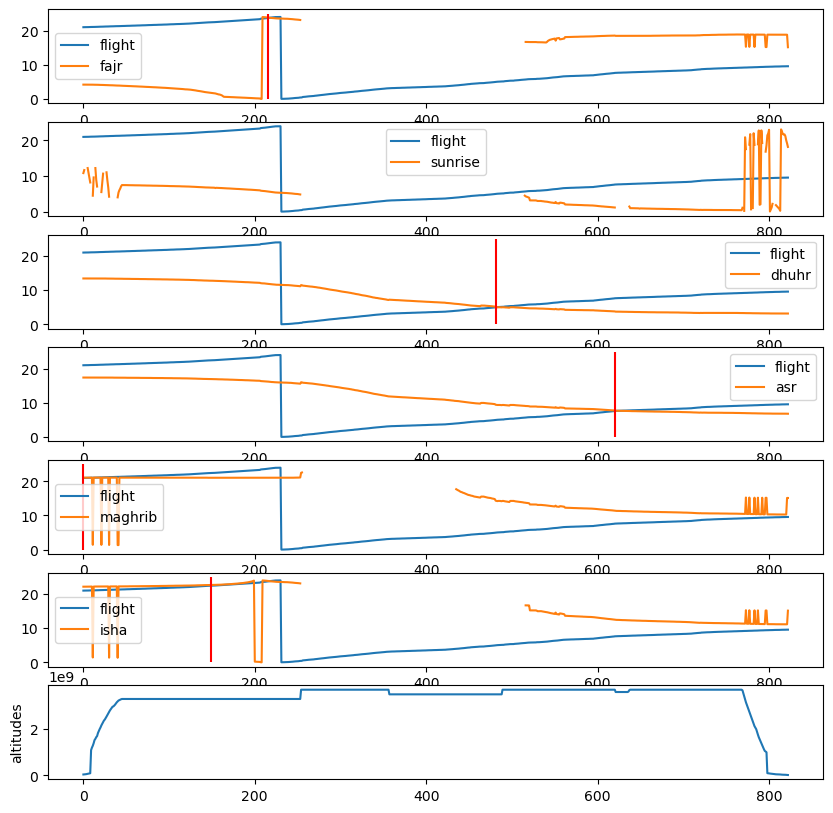

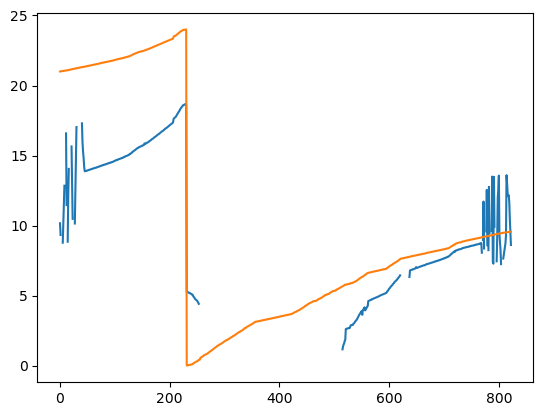

In [109]:
# Todos:
#1. Order printing chronologically
#2. Add qibla
#3. Timezone!

diff_dhuhr = np.abs(dhuhr_times - flight_times)
diff_asr = np.abs(asr_times - flight_times)
diff_maghrib = np.abs(maghrib_times - flight_times)
diff_isha = np.abs(isha_times - flight_times)
diff_fajr = np.abs(fajr_times - flight_times)
diff_sunrise = np.abs(sunrise_times - flight_times)


fig, ax = plt.subplots(7, figsize= (10,10) )
ax[0].plot(flight_times)
ax[1].plot(flight_times)
ax[2].plot(flight_times)
ax[3].plot(flight_times)
ax[4].plot(flight_times)
ax[5].plot(flight_times)

ax[0].plot(fajr_times)
ax[1].plot(sunrise_times)
ax[2].plot(dhuhr_times)
ax[3].plot(asr_times)
ax[4].plot(maghrib_times)
ax[5].plot(isha_times)


ax[0].legend(['flight', 'fajr'])
ax[1].legend(['flight', 'sunrise'])
ax[2].legend(['flight', 'dhuhr'])
ax[3].legend(['flight', 'asr'])
ax[4].legend(['flight', 'maghrib'])
ax[5].legend(['flight', 'isha'])

fajr_ind, fajr_time = calculate_inflight_prayertime(diff_fajr, flight_times)
sunrise_ind, sunrise_time = calculate_inflight_prayertime(diff_sunrise, flight_times)
dhuhr_ind, dhuhr_time = calculate_inflight_prayertime(diff_dhuhr, flight_times)
asr_ind, asr_time = calculate_inflight_prayertime(diff_asr, flight_times)
maghrib_ind, maghrib_time = calculate_inflight_prayertime(diff_maghrib, flight_times)
isha_ind, isha_time = calculate_inflight_prayertime(diff_isha, flight_times)

ax[0].vlines(fajr_ind, 0 ,25, color = 'Red')
ax[1].vlines(sunrise_ind, 0 ,25, color = 'Red')
ax[2].vlines(dhuhr_ind, 0 ,25, color = 'Red')
ax[3].vlines(asr_ind, 0 ,25, color = 'Red')
ax[4].vlines(maghrib_ind, 0 ,25, color = 'Red')
ax[5].vlines(isha_ind, 0 ,25, color = 'Red')

print(f'Fajr Time is at {fajr_time}')
print(f'Sunrise Time is at {sunrise_time}')
print(f'Dhuhr Time is at {dhuhr_time}')
print(f'Asr Time is at {asr_time}')
print(f'Maghrib Time is at {maghrib_time}')
print(f'Isha Time is at {isha_time}')

ax[6].plot(altitudes)
ax[6].set_ylabel('altitudes')

fig, ax = plt.subplots()
ax.plot(diff_sunrise, label = 'diff')
ax.plot(flight_times)

# Debug

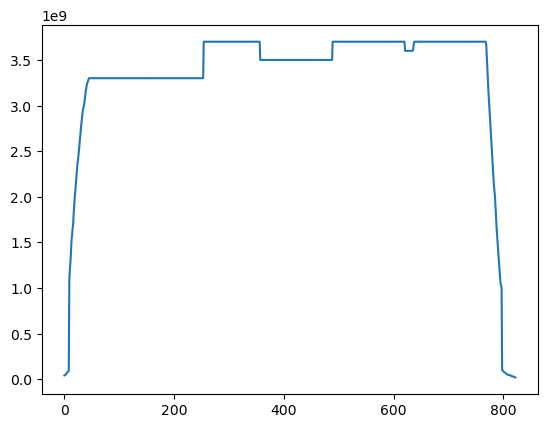

In [51]:
prayTimes.setMethod('Tehran') #paramaterS: MWL, ISNA, Egypt, Makkah, Karachi, Tehran, Jafari
date = (2025, 8, 1)
format = "%I:%M %p"


NumRecords = len(df)
altitudes = np.zeros(NumRecords)


end_row = df['LatitudeLat'].str.contains('Surface').count()
invalidTime =  '-----'
prev_height = 0
ind = 0
for ind_rec, row in df.iterrows():
    #print(ind_rec)
    # height = 35#35000
    height = float(get_repeated_substring(str(df.feet[ind_rec])))
    if np.isnan(height):
        altitudes[ind] = prev_height
    else:
        altitudes[ind] = height
        prev_height = height
    
#     loc_latitude = float(df.LatitudeLat[ind_rec][:6])
#     loc_longitude = float(df.LongitudeLon[ind_rec][:6])
#     coordinates = (loc_latitude, loc_longitude, height)
#     prayer_times = prayTimes.getTimes(date, coordinates, -4) # TODO: Currently it only calculates
#                                                              # Prayertimes relative to EST (-4 GST)

#     fajr_time = prayer_times['fajr']
#     dhuhr_time = prayer_times['dhuhr']
#     asr_time = prayer_times['asr']
#     maghrib_time = prayer_times['maghrib']
#     isha_time = prayer_times['isha']
#     sunrise_time = prayer_times['sunrise']
    
    
#     # Convert 12hr flight time to 2hrs and mins
#     ext_hr_flight, ext_mins_flight = Extract24HrTime(df['Time (EDT)EDT'][ind_rec][4:])

#     # Parses 24hr time into hrs and minutes
#     ext_hr_fajr, ext_mins_fajr = Parse24HrTime(fajr_time)
#     ext_hr_dhuhr, ext_mins_dhuhr = Parse24HrTime(dhuhr_time)
#     ext_hr_asr, ext_mins_asr = Parse24HrTime(asr_time)
#     ext_hr_maghrib, ext_mins_maghrib = Parse24HrTime(maghrib_time)
#     ext_hr_isha, ext_mins_isha = Parse24HrTime(isha_time)
#     ext_hr_sunrise, ext_mins_sunrise = Parse24HrTime(sunrise_time)

    
#     # Converts all times into just hours:
#     flight_times[ind] = np.mod(ext_hr_flight + ext_mins_flight/60 + time_correction, 24)
#     fajr_times[ind] = ext_hr_fajr + ext_mins_fajr/60
#     sunrise_times[ind] = ext_hr_sunrise + ext_mins_sunrise/60
#     dhuhr_times[ind] = ext_hr_dhuhr + ext_mins_dhuhr/60
#     asr_times[ind] = ext_hr_asr + ext_mins_asr/60
#     maghrib_times[ind] = ext_hr_maghrib + ext_mins_maghrib/60
#     isha_times[ind] = ext_hr_isha + ext_mins_isha/60
#     longitudes[ind] = loc_longitude
#     latitudes[ind] = loc_latitude
    ind +=1
    
fig, ax = plt.subplots()
ax.plot(altitudes)

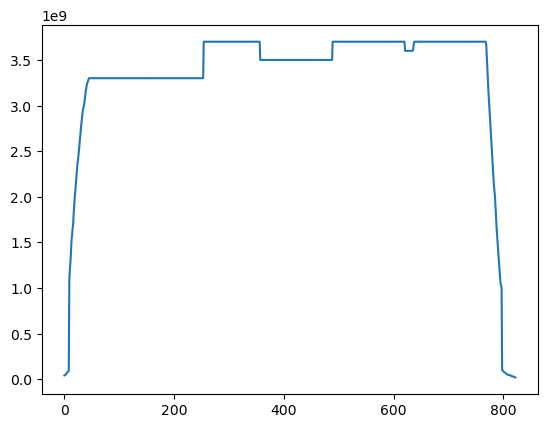

In [54]:
fig, ax = plt.subplots()
ax.plot(altitudes)

In [50]:
np.isnan(altitudes[200:300])

array([False, False, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

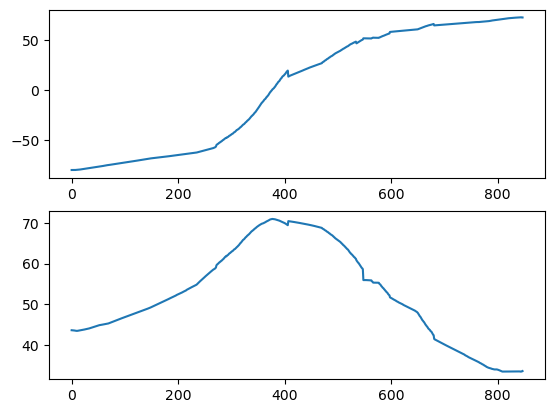

In [119]:
fig, ax = plt.subplots(2)
ax[0].plot(longitudes)
ax[1].plot(latitudes)


Dhuhr Time is at (12, 43.00000000000001, 'PM')
Maghrib Time is at nan
Fajr Time is at nan
Sunrise Time is at nan


/Users/zzaidi/anaconda3/lib/python3.11/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


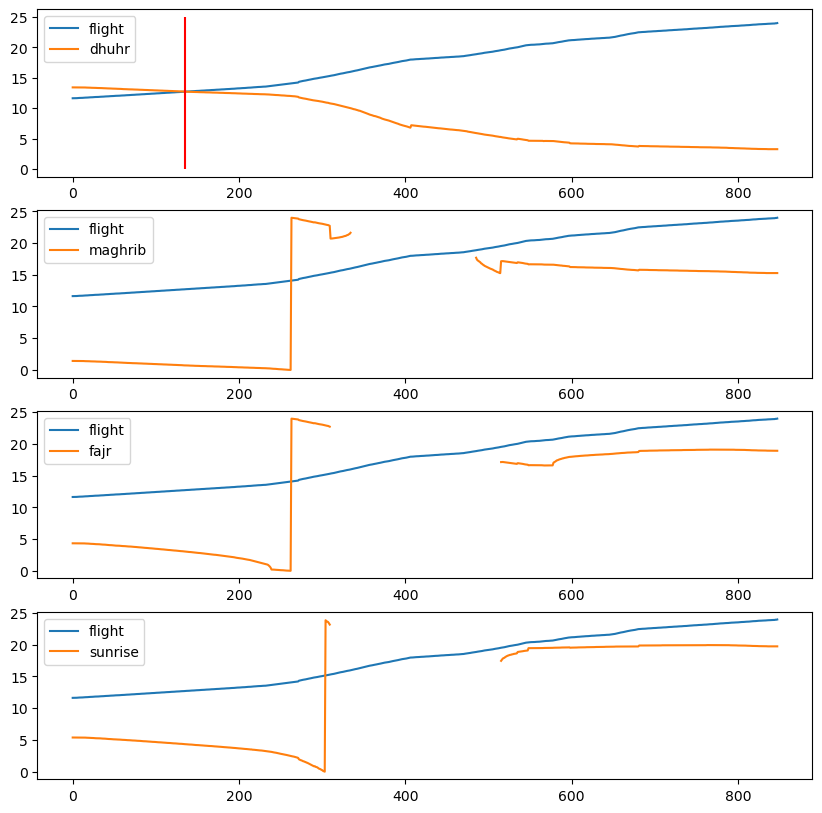

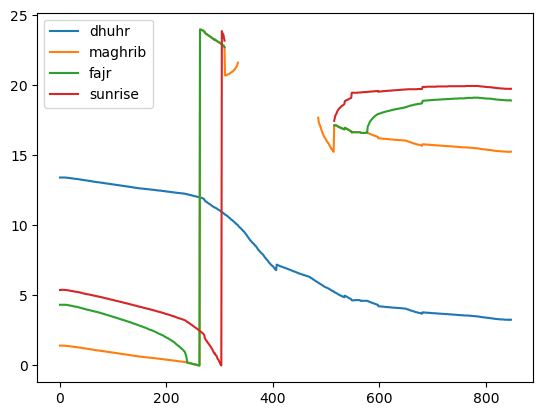

array([], shape=(0, 1), dtype=int64)

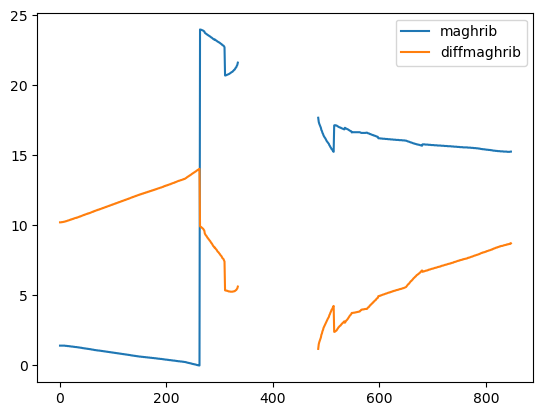

In [121]:
fig, ax = plt.subplots()
ax.plot(maghrib_times, label = 'maghrib')
ax.plot(diff_maghrib, label = 'diffmaghrib')
ax.legend()
np.argwhere(diff_maghrib == 0) 


array([[148],
       [149],
       [726],
       [727]])

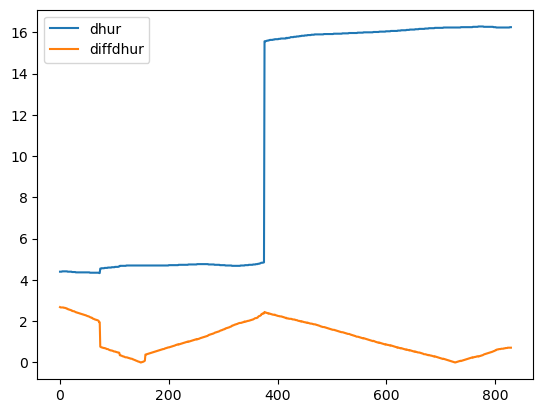

In [47]:
fig, ax = plt.subplots()
ax.plot(dhuhr_times, label = 'dhur')
ax.plot(diff_dhuhr, label = 'diffdhur')
ax.legend()

np.argwhere(diff_dhuhr == 0)

0.0


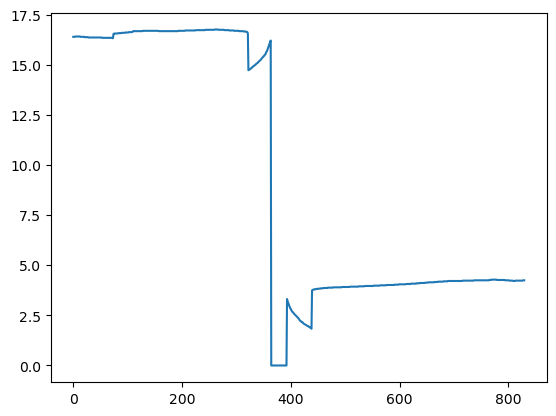

In [53]:
fig, ax = plt.subplots()
ax.plot(maghrib_times)

print(maghrib_times[380])

In [15]:
bad_maghrib = np.argwhere(maghrib_times == 0.0)

print(bad_maghrib[:,0])

bad_longitude = longitudes[bad_maghrib[0,0]]
bad_latitude = latitudes[bad_maghrib[0,0]]
print([bad_longitude, bad_latitude])



[364 365 366 367 368 369 370 371 372 373 374 375 376 377 378 379 380 381
 382 383 384 385 386 387 388 389 390 391 392]
[49.69, 64.135]


In [16]:
bad_coordinates = (bad_latitude, bad_longitude, height)
print(bad_coordinates)
prayer_times = prayTimes.getTimes(date, bad_coordinates, -4)#calculation_parameters=params)
invalidTime =  '-----'

(64.135, 49.69, 35000)


In [17]:
ext_hr_fajr, ext_mins_fajr = Extract24HrTime(prayer_times['fajr'])
fajr_time_temp = ext_hr_fajr + ext_mins_fajr/60
print(fajr_time_temp)

invalid time detected
nan


In [60]:
len(df)

578

In [69]:
np.arange(1,3)

array([1, 2])

In [73]:
df.to_csv('test.csv')

In [30]:
pd_flighthistory[1]

,0
0,Your browser is unsupported. upgrade your browser
